In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import accuracy_score

In [2]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

In [3]:
def convert2_zero_one(x):
    
    t = tf.math.sigmoid(x)
    #t = tf.cast(tf.math.greater(samples[0], 0.5), tf.int32)
    
    return t

In [4]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [121]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_current = [h_current[0]]
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = h_current[0]

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [104]:
model = StochasticMLP(hidden_layer_sizes = [2], n_outputs=1)

In [105]:
network = [model.call(images) for images, labels in train_ds]

In [106]:
# Set weight
w_0 = np.array([[1, -1], [1, -1]], dtype = "float32")
b_0 = np.array([-0.5, 1], dtype = "float32")
l_0 = [w_0, b_0]

w_1 = np.array([[1], [1]], dtype = "float32")
b_1 = np.array([-1], dtype = "float32")
l_1 = [w_1, b_1]

model.fc_layers[0].set_weights(l_0)
model.output_layer.set_weights(l_1)

In [107]:
network = [model.call(images) for images, labels in train_ds]
network

[[<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
  array([[0, 1],
         [1, 1],
         [1, 0],
         [1, 0]], dtype=int32)>]]

In [108]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [78]:
burnin = 1000
step_sizes = []
for i in range(burnin):
    
    network_new = []
    kernels_new = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2][4].numpy()
        step_sizes.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [2], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    #print(network[0])

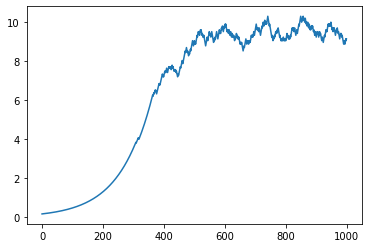

In [79]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()

In [109]:
print(network[0])

[<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[0, 1],
       [1, 1],
       [1, 0],
       [1, 0]], dtype=int32)>]


In [113]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(images, network[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new = []
        kernels_new = []
        for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [2], axis = 1)   
            network_new.append(net_new)
            
            ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
            kernels_new.append(ker_new)
            
        network = network_new
        kernels = kernels_new
        
        loss += -1 * tf.reduce_mean(model.target_log_prob(images, network[bs], labels))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    #print(preds)
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

tf.Tensor(
[[0.16394104]
 [0.5952626 ]
 [0.5943215 ]
 [0.63487077]], shape=(4, 1), dtype=float32)
Epoch 1/500: - 0.0606s/step - loss: 0.6584 - accuracy: 0.7500
tf.Tensor(
[[0.1634818 ]
 [0.59486514]
 [0.5939297 ]
 [0.6346182 ]], shape=(4, 1), dtype=float32)
Epoch 2/500: - 0.0713s/step - loss: 0.6581 - accuracy: 0.7500
tf.Tensor(
[[0.16303499]
 [0.5944918 ]
 [0.5935621 ]
 [0.634387  ]], shape=(4, 1), dtype=float32)
Epoch 3/500: - 0.0636s/step - loss: 0.6577 - accuracy: 0.7500
tf.Tensor(
[[0.16259997]
 [0.5941414 ]
 [0.59321725]
 [0.634176  ]], shape=(4, 1), dtype=float32)
Epoch 4/500: - 0.0589s/step - loss: 0.6573 - accuracy: 0.7500
tf.Tensor(
[[0.16217613]
 [0.59381264]
 [0.5928941 ]
 [0.633984  ]], shape=(4, 1), dtype=float32)
Epoch 5/500: - 0.0570s/step - loss: 0.6570 - accuracy: 0.7500
tf.Tensor(
[[0.16176277]
 [0.5935044 ]
 [0.5925914 ]
 [0.63381016]], shape=(4, 1), dtype=float32)
Epoch 6/500: - 0.0584s/step - loss: 0.6566 - accuracy: 0.7500
tf.Tensor(
[[0.16135946]
 [0.5932156 ]
 

tf.Tensor(
[[0.14811035]
 [0.5901071 ]
 [0.5893943 ]
 [0.6347666 ]], shape=(4, 1), dtype=float32)
Epoch 54/500: - 0.0516s/step - loss: 0.6431 - accuracy: 0.7500
tf.Tensor(
[[0.14788589]
 [0.5901343 ]
 [0.5894247 ]
 [0.6348559 ]], shape=(4, 1), dtype=float32)
Epoch 55/500: - 0.0522s/step - loss: 0.6429 - accuracy: 0.7500
tf.Tensor(
[[0.1476626 ]
 [0.59016263]
 [0.5894562 ]
 [0.63494563]], shape=(4, 1), dtype=float32)
Epoch 56/500: - 0.0527s/step - loss: 0.6426 - accuracy: 0.7500
tf.Tensor(
[[0.14744037]
 [0.5901921 ]
 [0.58948886]
 [0.6350354 ]], shape=(4, 1), dtype=float32)
Epoch 57/500: - 0.0529s/step - loss: 0.6424 - accuracy: 0.7500
tf.Tensor(
[[0.14721924]
 [0.5902225 ]
 [0.5895224 ]
 [0.6351253 ]], shape=(4, 1), dtype=float32)
Epoch 58/500: - 0.0533s/step - loss: 0.6422 - accuracy: 0.7500
tf.Tensor(
[[0.14699912]
 [0.5902539 ]
 [0.5895569 ]
 [0.63521546]], shape=(4, 1), dtype=float32)
Epoch 59/500: - 0.0537s/step - loss: 0.6419 - accuracy: 0.7500
tf.Tensor(
[[0.14678001]
 [0.59028

tf.Tensor(
[[0.14220366]
 [0.58264136]
 [0.5820833 ]
 [0.62250924]], shape=(4, 1), dtype=float32)
Epoch 106/500: - 0.0545s/step - loss: 0.6365 - accuracy: 0.7500
tf.Tensor(
[[0.14228868]
 [0.58354294]
 [0.58298665]
 [0.6234844 ]], shape=(4, 1), dtype=float32)
Epoch 107/500: - 0.0548s/step - loss: 0.6364 - accuracy: 0.7500
tf.Tensor(
[[0.14235523]
 [0.584393  ]
 [0.5838385 ]
 [0.6244075 ]], shape=(4, 1), dtype=float32)
Epoch 108/500: - 0.0550s/step - loss: 0.6362 - accuracy: 0.7500
tf.Tensor(
[[0.14240432]
 [0.5851958 ]
 [0.58464277]
 [0.62528294]], shape=(4, 1), dtype=float32)
Epoch 109/500: - 0.0551s/step - loss: 0.6359 - accuracy: 0.7500
tf.Tensor(
[[0.14243695]
 [0.5859536 ]
 [0.5854024 ]
 [0.6261134 ]], shape=(4, 1), dtype=float32)
Epoch 110/500: - 0.0553s/step - loss: 0.6355 - accuracy: 0.7500
tf.Tensor(
[[0.142454  ]
 [0.58667034]
 [0.5861207 ]
 [0.6269032 ]], shape=(4, 1), dtype=float32)
Epoch 111/500: - 0.0553s/step - loss: 0.6353 - accuracy: 0.7500
tf.Tensor(
[[0.14245641]
 [0

tf.Tensor(
[[0.14256904]
 [0.60542446]
 [0.60979867]
 [0.6547277 ]], shape=(4, 1), dtype=float32)
Epoch 159/500: - 0.0551s/step - loss: 0.6309 - accuracy: 0.7500
tf.Tensor(
[[0.14205468]
 [0.6046377 ]
 [0.6090064 ]
 [0.65398574]], shape=(4, 1), dtype=float32)
Epoch 160/500: - 0.0551s/step - loss: 0.6307 - accuracy: 0.7500
tf.Tensor(
[[0.14155944]
 [0.603895  ]
 [0.60825783]
 [0.6532856 ]], shape=(4, 1), dtype=float32)
Epoch 161/500: - 0.0551s/step - loss: 0.6308 - accuracy: 0.7500
tf.Tensor(
[[0.14108221]
 [0.60319245]
 [0.6075493 ]
 [0.65262264]], shape=(4, 1), dtype=float32)
Epoch 162/500: - 0.0550s/step - loss: 0.6303 - accuracy: 0.7500
tf.Tensor(
[[0.14062224]
 [0.6025314 ]
 [0.60688215]
 [0.6520002 ]], shape=(4, 1), dtype=float32)
Epoch 163/500: - 0.0550s/step - loss: 0.6301 - accuracy: 0.7500
tf.Tensor(
[[0.14017838]
 [0.60190785]
 [0.6062526 ]
 [0.6514133 ]], shape=(4, 1), dtype=float32)
Epoch 164/500: - 0.0550s/step - loss: 0.6299 - accuracy: 0.7500
tf.Tensor(
[[0.13974977]
 [0

tf.Tensor(
[[0.12770653]
 [0.59326357]
 [0.59726465]
 [0.64344406]], shape=(4, 1), dtype=float32)
Epoch 213/500: - 0.0540s/step - loss: 0.6223 - accuracy: 0.7500
tf.Tensor(
[[0.12753224]
 [0.59327286]
 [0.59726673]
 [0.64345694]], shape=(4, 1), dtype=float32)
Epoch 214/500: - 0.0540s/step - loss: 0.6235 - accuracy: 0.7500
tf.Tensor(
[[0.12735912]
 [0.5932786 ]
 [0.5972651 ]
 [0.6434623 ]], shape=(4, 1), dtype=float32)
Epoch 215/500: - 0.0539s/step - loss: 0.6225 - accuracy: 0.7500
tf.Tensor(
[[0.12718727]
 [0.5932903 ]
 [0.5972697 ]
 [0.6434757 ]], shape=(4, 1), dtype=float32)
Epoch 216/500: - 0.0539s/step - loss: 0.6224 - accuracy: 0.7500
tf.Tensor(
[[0.1270165 ]
 [0.59330416]
 [0.5972764 ]
 [0.6434908 ]], shape=(4, 1), dtype=float32)
Epoch 217/500: - 0.0538s/step - loss: 0.6223 - accuracy: 0.7500
tf.Tensor(
[[0.12684685]
 [0.59332   ]
 [0.59728515]
 [0.6435079 ]], shape=(4, 1), dtype=float32)
Epoch 218/500: - 0.0538s/step - loss: 0.6221 - accuracy: 0.7500
tf.Tensor(
[[0.1266782 ]
 [0

tf.Tensor(
[[0.12358129]
 [0.599856  ]
 [0.60327685]
 [0.6466949 ]], shape=(4, 1), dtype=float32)
Epoch 267/500: - 0.0535s/step - loss: 1.3602 - accuracy: 0.7500
tf.Tensor(
[[0.12594813]
 [0.6064158 ]
 [0.6097997 ]
 [0.652652  ]], shape=(4, 1), dtype=float32)
Epoch 268/500: - 0.0535s/step - loss: 0.6546 - accuracy: 0.7500
tf.Tensor(
[[0.12578312]
 [0.6063892 ]
 [0.60976785]
 [0.6526264 ]], shape=(4, 1), dtype=float32)
Epoch 269/500: - 0.0535s/step - loss: 0.6579 - accuracy: 0.7500
tf.Tensor(
[[0.12561966]
 [0.60635024]
 [0.609723  ]
 [0.65257967]], shape=(4, 1), dtype=float32)
Epoch 270/500: - 0.0535s/step - loss: 0.6544 - accuracy: 0.7500
tf.Tensor(
[[0.12545742]
 [0.6063292 ]
 [0.6096967 ]
 [0.652559  ]], shape=(4, 1), dtype=float32)
Epoch 271/500: - 0.0536s/step - loss: 0.6543 - accuracy: 0.7500
tf.Tensor(
[[0.12529637]
 [0.60631037]
 [0.6096725 ]
 [0.6525402 ]], shape=(4, 1), dtype=float32)
Epoch 272/500: - 0.0536s/step - loss: 0.6542 - accuracy: 0.7500
tf.Tensor(
[[0.12513644]
 [0

Epoch 318/500: - 0.0540s/step - loss: 0.6124 - accuracy: 0.7500
tf.Tensor(
[[0.1155435 ]
 [0.5999043 ]
 [0.60306996]
 [0.6470001 ]], shape=(4, 1), dtype=float32)
Epoch 319/500: - 0.0540s/step - loss: 0.6151 - accuracy: 0.7500
tf.Tensor(
[[0.1153797]
 [0.5998653]
 [0.6030265]
 [0.6469683]], shape=(4, 1), dtype=float32)
Epoch 320/500: - 0.0540s/step - loss: 0.6122 - accuracy: 0.7500
tf.Tensor(
[[0.11521714]
 [0.59984124]
 [0.60299784]
 [0.6469574 ]], shape=(4, 1), dtype=float32)
Epoch 321/500: - 0.0540s/step - loss: 0.6121 - accuracy: 0.7500
tf.Tensor(
[[0.1150559 ]
 [0.5998198 ]
 [0.6029723 ]
 [0.64694923]], shape=(4, 1), dtype=float32)
Epoch 322/500: - 0.0541s/step - loss: 0.6119 - accuracy: 0.7500
tf.Tensor(
[[0.11489595]
 [0.59980124]
 [0.60294944]
 [0.64694345]], shape=(4, 1), dtype=float32)
Epoch 323/500: - 0.0542s/step - loss: 1.8111 - accuracy: 0.7500
tf.Tensor(
[[0.11460428]
 [0.60052145]
 [0.60374814]
 [0.64760816]], shape=(4, 1), dtype=float32)
Epoch 324/500: - 0.0541s/step - 

tf.Tensor(
[[0.10755558]
 [0.59403354]
 [0.5968784 ]
 [0.639558  ]], shape=(4, 1), dtype=float32)
Epoch 371/500: - 0.0529s/step - loss: 0.6087 - accuracy: 0.7500
tf.Tensor(
[[0.10754928]
 [0.5944968 ]
 [0.59733784]
 [0.64002883]], shape=(4, 1), dtype=float32)
Epoch 372/500: - 0.0528s/step - loss: 0.6086 - accuracy: 0.7500
tf.Tensor(
[[0.10753606]
 [0.5949361 ]
 [0.59777343]
 [0.6404758 ]], shape=(4, 1), dtype=float32)
Epoch 373/500: - 0.0528s/step - loss: 0.6085 - accuracy: 0.7500
tf.Tensor(
[[0.10751626]
 [0.5953527 ]
 [0.59818643]
 [0.6409003 ]], shape=(4, 1), dtype=float32)
Epoch 374/500: - 0.0528s/step - loss: 0.6084 - accuracy: 0.7500
tf.Tensor(
[[0.10749033]
 [0.59574765]
 [0.5985778 ]
 [0.64130384]], shape=(4, 1), dtype=float32)
Epoch 375/500: - 0.0527s/step - loss: 0.6083 - accuracy: 0.7500
tf.Tensor(
[[0.10745858]
 [0.59612244]
 [0.59894896]
 [0.6416873 ]], shape=(4, 1), dtype=float32)
Epoch 376/500: - 0.0527s/step - loss: 0.6076 - accuracy: 0.7500
tf.Tensor(
[[0.1074193]
 [0.

tf.Tensor(
[[0.1026742]
 [0.6027582]
 [0.6054006]
 [0.6486713]], shape=(4, 1), dtype=float32)
Epoch 426/500: - 0.0524s/step - loss: 1.4370 - accuracy: 0.7500
tf.Tensor(
[[0.10469194]
 [0.6092175 ]
 [0.61183316]
 [0.6545979 ]], shape=(4, 1), dtype=float32)
Epoch 427/500: - 0.0524s/step - loss: 1.4016 - accuracy: 0.7500
tf.Tensor(
[[0.1066619 ]
 [0.61541367]
 [0.6180036 ]
 [0.66026825]], shape=(4, 1), dtype=float32)
Epoch 428/500: - 0.0524s/step - loss: 1.3813 - accuracy: 0.7500
tf.Tensor(
[[0.10858607]
 [0.62130564]
 [0.6238691 ]
 [0.6656088 ]], shape=(4, 1), dtype=float32)
Epoch 429/500: - 0.0524s/step - loss: 1.3612 - accuracy: 0.7500
tf.Tensor(
[[0.1104649 ]
 [0.6269092 ]
 [0.62944543]
 [0.67063475]], shape=(4, 1), dtype=float32)
Epoch 430/500: - 0.0524s/step - loss: 1.3414 - accuracy: 0.7500
tf.Tensor(
[[0.112299  ]
 [0.63223857]
 [0.63474697]
 [0.6753606 ]], shape=(4, 1), dtype=float32)
Epoch 431/500: - 0.0524s/step - loss: 1.3219 - accuracy: 0.7500
tf.Tensor(
[[0.11408896]
 [0.637

tf.Tensor(
[[0.10044108]
 [0.60731906]
 [0.6096141 ]
 [0.6493737 ]], shape=(4, 1), dtype=float32)
Epoch 480/500: - 0.0522s/step - loss: 0.6053 - accuracy: 0.7500
tf.Tensor(
[[0.10027503]
 [0.60717374]
 [0.60946673]
 [0.6492603 ]], shape=(4, 1), dtype=float32)
Epoch 481/500: - 0.0522s/step - loss: 0.6052 - accuracy: 0.7500
tf.Tensor(
[[0.10011197]
 [0.60703754]
 [0.6093281 ]
 [0.6491551 ]], shape=(4, 1), dtype=float32)
Epoch 482/500: - 0.0522s/step - loss: 0.6058 - accuracy: 0.7500
tf.Tensor(
[[0.09995456]
 [0.6069183 ]
 [0.60920674]
 [0.64906526]], shape=(4, 1), dtype=float32)
Epoch 483/500: - 0.0522s/step - loss: 0.6050 - accuracy: 0.7500
tf.Tensor(
[[0.0997968]
 [0.606798 ]
 [0.6090842]
 [0.6489751]], shape=(4, 1), dtype=float32)
Epoch 484/500: - 0.0521s/step - loss: 0.6048 - accuracy: 0.7500
tf.Tensor(
[[0.0996416 ]
 [0.60668534]
 [0.60896933]
 [0.64889175]], shape=(4, 1), dtype=float32)
Epoch 485/500: - 0.0521s/step - loss: 0.6047 - accuracy: 0.7500
tf.Tensor(
[[0.09948882]
 [0.606

In [91]:
print(model.trainable_weights)

[<tf.Variable 'dense_18/kernel:0' shape=(2, 2) dtype=float32, numpy=
array([[ 4.817084  , -0.05097213],
       [ 4.7562203 ,  0.12390304]], dtype=float32)>, <tf.Variable 'dense_18/bias:0' shape=(2,) dtype=float32, numpy=array([-1.6865604,  3.6418037], dtype=float32)>, <tf.Variable 'dense_19/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[ 3.7582612 ],
       [-0.36850855]], dtype=float32)>, <tf.Variable 'dense_19/bias:0' shape=(1,) dtype=float32, numpy=array([-2.7468002], dtype=float32)>]


In [126]:
model2 = StochasticMLP(hidden_layer_sizes = [30], n_outputs=1)
network2 = [model2.call(images) for images, labels in train_ds]
kernels2 = [model2.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [127]:
print(network2)

[[<tf.Tensor: shape=(4, 30), dtype=int32, numpy=
array([[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0]], dtype=int32)>]]


In [128]:
burnin = 1000
step_sizes2 = []
for i in range(burnin):
    
    #print(i)
    network_new2 = []
    kernels_new2 = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2][4].numpy()
        step_sizes2.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        #print(new_state)
        net_new = tf.split(new_state, [30], axis = 1)   
        network_new2.append(net_new)
        
        # build new kernel
        ker_new = model2.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new2.append(ker_new)
            
    network2 = network_new2
    kernels2 = kernels_new2
    

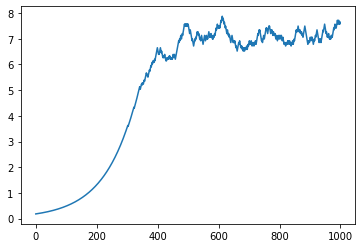

In [129]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes2)), step_sizes2)
plt.show()

In [130]:
print(network2[0])

[<tf.Tensor: shape=(4, 30), dtype=float32, numpy=
array([[ 3.4881892 ,  6.        ,  6.        ,  3.175901  , -6.        ,
        -1.0908687 , -4.4888287 ,  6.        , -0.8854478 , -6.        ,
        -0.5336058 , -6.        , -6.        ,  6.        , -6.        ,
         1.3827236 ,  6.        , -6.        , -6.        , -6.        ,
         6.        ,  6.        ,  6.        ,  6.        ,  2.5057468 ,
         3.3253698 ,  6.        ,  6.        , -6.        , -1.6928031 ],
       [ 6.        ,  6.        , -6.        ,  6.        ,  5.064812  ,
         6.        ,  6.        , -3.4218678 ,  6.        ,  3.1529286 ,
        -2.042216  , -2.2894542 ,  6.        , -6.        , -0.762521  ,
        -4.4954195 ,  6.        , -4.8549685 ,  6.        ,  0.15746999,
         6.        ,  6.        , -6.        , -6.        ,  2.6048872 ,
        -6.        , -6.        ,  6.        ,  6.        , -6.        ],
       [-6.        ,  6.        , -3.948919  ,  6.        , -6.        ,

In [131]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (images, labels) in enumerate(train_ds):
        
        # only one mini-batch
        model2.update_weights(images, network2[bs], labels, 0.1)
        #network_new = [model.propose_new_state_hamiltonian(images, net, labels) for (images, labels), net in 
        #               zip(train_ds, network)]
        
        network_new2 = []
        kernels_new2 = []
        for (images, labels), net, hmc_kernel in zip(train_ds, network2, kernels2):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [30], axis = 1)   
            network_new2.append(net_new)
            
            ker_new = model2.generate_hmc_kernel(images, labels, new_step_size)
            kernels_new2.append(ker_new)
            
        network2 = network_new2
        kernels2 = kernels_new2
        
        loss += -1 * tf.reduce_mean(model2.target_log_prob(images, network2[bs], labels))
    
    preds = [model2.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.array(preds[0]), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))

Epoch 1/500: - 0.0586s/step - loss: 20.7884 - accuracy: 0.5000
Epoch 2/500: - 0.0646s/step - loss: 20.8240 - accuracy: 0.5000
Epoch 3/500: - 0.0594s/step - loss: 20.4959 - accuracy: 0.5000
Epoch 4/500: - 0.0552s/step - loss: 20.3755 - accuracy: 0.5000
Epoch 5/500: - 0.0538s/step - loss: 20.0259 - accuracy: 0.5000
Epoch 6/500: - 0.0547s/step - loss: 19.7696 - accuracy: 0.5000
Epoch 7/500: - 0.0532s/step - loss: 19.5285 - accuracy: 0.5000
Epoch 8/500: - 0.0515s/step - loss: 19.7812 - accuracy: 0.5000
Epoch 9/500: - 0.0500s/step - loss: 19.0776 - accuracy: 0.5000
Epoch 10/500: - 0.0497s/step - loss: 18.7998 - accuracy: 0.5000
Epoch 11/500: - 0.0498s/step - loss: 18.5214 - accuracy: 0.5000
Epoch 12/500: - 0.0489s/step - loss: 18.3802 - accuracy: 0.5000
Epoch 13/500: - 0.0482s/step - loss: 18.1696 - accuracy: 0.5000
Epoch 14/500: - 0.0479s/step - loss: 18.6160 - accuracy: 0.5000
Epoch 15/500: - 0.0483s/step - loss: 18.0278 - accuracy: 0.5000
Epoch 16/500: - 0.0490s/step - loss: 18.7728 - ac

Epoch 130/500: - 0.0515s/step - loss: 7.9794 - accuracy: 0.7500
Epoch 131/500: - 0.0515s/step - loss: 7.9476 - accuracy: 0.7500
Epoch 132/500: - 0.0517s/step - loss: 7.9163 - accuracy: 0.7500
Epoch 133/500: - 0.0519s/step - loss: 7.8855 - accuracy: 0.7500
Epoch 134/500: - 0.0522s/step - loss: 7.8552 - accuracy: 0.7500
Epoch 135/500: - 0.0523s/step - loss: 7.8253 - accuracy: 0.7500
Epoch 136/500: - 0.0523s/step - loss: 7.7959 - accuracy: 0.7500
Epoch 137/500: - 0.0522s/step - loss: 7.7669 - accuracy: 0.7500
Epoch 138/500: - 0.0522s/step - loss: 7.7383 - accuracy: 0.7500
Epoch 139/500: - 0.0522s/step - loss: 7.7101 - accuracy: 0.7500
Epoch 140/500: - 0.0521s/step - loss: 7.6823 - accuracy: 0.7500
Epoch 141/500: - 0.0521s/step - loss: 7.6550 - accuracy: 0.7500
Epoch 142/500: - 0.0520s/step - loss: 7.6280 - accuracy: 0.7500
Epoch 143/500: - 0.0519s/step - loss: 7.6013 - accuracy: 0.7500
Epoch 144/500: - 0.0519s/step - loss: 7.5751 - accuracy: 0.7500
Epoch 145/500: - 0.0519s/step - loss: 7.

Epoch 260/500: - 0.0540s/step - loss: 5.8085 - accuracy: 1.0000
Epoch 261/500: - 0.0539s/step - loss: 5.7994 - accuracy: 1.0000
Epoch 262/500: - 0.0539s/step - loss: 5.7903 - accuracy: 1.0000
Epoch 263/500: - 0.0539s/step - loss: 5.7812 - accuracy: 1.0000
Epoch 264/500: - 0.0538s/step - loss: 5.7722 - accuracy: 1.0000
Epoch 265/500: - 0.0538s/step - loss: 5.7633 - accuracy: 1.0000
Epoch 266/500: - 0.0539s/step - loss: 5.7544 - accuracy: 1.0000
Epoch 267/500: - 0.0539s/step - loss: 5.7456 - accuracy: 1.0000
Epoch 268/500: - 0.0539s/step - loss: 5.7368 - accuracy: 1.0000
Epoch 269/500: - 0.0539s/step - loss: 5.7281 - accuracy: 1.0000
Epoch 270/500: - 0.0539s/step - loss: 5.7194 - accuracy: 1.0000
Epoch 271/500: - 0.0540s/step - loss: 5.7108 - accuracy: 1.0000
Epoch 272/500: - 0.0539s/step - loss: 5.7022 - accuracy: 1.0000
Epoch 273/500: - 0.0540s/step - loss: 5.6937 - accuracy: 1.0000
Epoch 274/500: - 0.0539s/step - loss: 5.6853 - accuracy: 1.0000
Epoch 275/500: - 0.0539s/step - loss: 5.

Epoch 389/500: - 0.0529s/step - loss: 4.9693 - accuracy: 1.0000
Epoch 390/500: - 0.0528s/step - loss: 4.9647 - accuracy: 1.0000
Epoch 391/500: - 0.0528s/step - loss: 4.9602 - accuracy: 1.0000
Epoch 392/500: - 0.0528s/step - loss: 4.9556 - accuracy: 1.0000
Epoch 393/500: - 0.0528s/step - loss: 4.9511 - accuracy: 1.0000
Epoch 394/500: - 0.0528s/step - loss: 4.9465 - accuracy: 1.0000
Epoch 395/500: - 0.0528s/step - loss: 4.9420 - accuracy: 1.0000
Epoch 396/500: - 0.0529s/step - loss: 4.9375 - accuracy: 1.0000
Epoch 397/500: - 0.0529s/step - loss: 4.9331 - accuracy: 1.0000
Epoch 398/500: - 0.0530s/step - loss: 4.9286 - accuracy: 1.0000
Epoch 399/500: - 0.0530s/step - loss: 4.9242 - accuracy: 1.0000
Epoch 400/500: - 0.0531s/step - loss: 4.9198 - accuracy: 1.0000
Epoch 401/500: - 0.0531s/step - loss: 4.9154 - accuracy: 1.0000
Epoch 402/500: - 0.0531s/step - loss: 4.9111 - accuracy: 1.0000
Epoch 403/500: - 0.0531s/step - loss: 4.9067 - accuracy: 1.0000
Epoch 404/500: - 0.0531s/step - loss: 4.